In [13]:
import subprocess, sys, pickle, blosc, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from csv_load import * 

In [14]:
my_os=sys.platform
os_change=True
if my_os=='darwin' or my_os=='linux':
    os_change=False

#

# 1. Reading csv files

## Loading a 'practice' file
Here some files paths are selected to obtain our first analyses and visualisations.

In [8]:
practice_object = "../../files/utf8/Object_Hit_-_[Child_-_practice]_-_RIGHT_-_12_02.csv"
circuit = "../../files/utf8/Circuit_Exo_-_[b_Circuit1_(youngerchildren)]_-_RIGHT_-_12_09.csv"

#files = [reaching, reaching2, practice_ball, practice_ball, ball, practice_object, circuit, circuit2, circuit3]

## First plots

In [53]:
FILEPATH = practice_object
dataframe = pd.read_csv(FILEPATH,encoding= 'unicode_escape', sep=',',skiprows = 390, parse_dates=[0,1,2])

gazeX = dataframe['Gaze_X']
gazeY = dataframe['Gaze_Y']
duration = dataframe['Sample duration (s)'][0]*dataframe['Sample count'][0]

print(dataframe['Frame time (s)'].values[-1])

# Time interval between frames(rows): 5ms
print('Total time of the practice (s):', duration)
#results['Frame time (s)'].iloc[-1] / 0.005
print('Time interval (refresh rate) between each rows (s):', dataframe['Sample duration (s)'].iloc[0])

16.7299995
Total time of the practice (s): 16.735
Time interval (refresh rate) between each rows (s): 0.005


In [37]:
# Columns of interest: 
# Event name
# Amplitude	 Accuracy(bob)	Duration 	Saccades shift 
dataframe.columns.values

array(['Trial #', 'TP Row', 'Block Row', 'Sample duration (s)',
       'Sample count', 'Event name', 'Event time (s)', 'Video frame sent',
       'Video frame ACKed', 'Frame #', 'Frame time (s)', 'Right_L1Ang',
       'Right_L2Ang', 'Right_L1Vel', 'Right_L2Vel', 'Right_L1Acc',
       'Right_L2Acc', 'Right_M1TorCMD', 'Right_M2TorCMD',
       'Right_RecTorque_M1', 'Right_RecTorque_M2', 'Left_L1Ang',
       'Left_L2Ang', 'Left_L1Vel', 'Left_L2Vel', 'Left_L1Acc',
       'Left_L2Acc', 'Left_M1TorCMD', 'Left_M2TorCMD',
       'Left_RecTorque_M1', 'Left_RecTorque_M2', 'Gaze_X', 'Gaze_Y',
       'Gaze_TimeStamp', 'Gaze_PupilArea', 'Gaze_Vector_X',
       'Gaze_Vector_Y', 'Gaze_Vector_Z', 'Gaze_Pupil_X', 'Gaze_Pupil_Y',
       'Gaze_Pupil_Z', 'StatusBits', 'ACH0', 'ACH1', 'ACH2', 'ACH3',
       'event_supplement', 'CH1_x', 'CH1_y', 'CH2_x', 'CH2_y', 'CH3_x',
       'CH3_y', 'CH4_x', 'CH4_y', 'CH5_x', 'CH5_y', 'CH6_x', 'CH6_y',
       'CH7_x', 'CH7_y', 'CH8_x', 'CH8_y', 'CH9_x', 'CH9_y', 'CH10_x

In [64]:
dataframe[dataframe['Event name'] == 'Continue Task']

,Trial #,TP Row,Block Row,Sample duration (s),Sample count,Event name,Event time (s),Video frame sent,Video frame ACKed,Frame #,...,Left: Shoulder angle,Left: Elbow angle,Left: Shoulder velocity,Left: Elbow velocity,Left: Shoulder acceleration,Left: Elbow acceleration,Left: Cmd shoulder torque,Left: Cmd elbow torque,Video frame interval time,Video frame drop count
0,1,1,1,0.005,3347.0,Continue Task,0.0,NaN,NaN,0,...,0.479841,1.396012,0.009587,-0.009587,9.587379,-19.174759,0.0,0.0,9.0,0


In [61]:
dataframe['Event name'].unique()

array(['Continue Task', 'Gaze blink start', 'Gaze saccade start', nan,
       'Gaze blink end', 'Gaze saccade end', 'Gaze fixation start',
       'Gaze fixation end'], dtype=object)

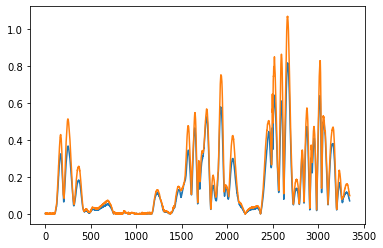

In [49]:
lspeed = dataframe['Left: Hand speed'].values
lvelx = dataframe['Left: Hand velocity X'].values
lvely = dataframe['Left: Hand velocity Y'].values
ll1 = dataframe['Left_L1Ang'].values
ll2 = dataframe['Left_L2Ang'].values
rl1 = dataframe['Right_L1Ang'].values
rl2 = dataframe['Right_L2Ang'].values

# plt.plot(rl1)
# plt.plot(rl2)

plt.plot(lspeed)
plt.plot(np.abs(lvely)+np.abs(lvelx))
#plt.plot(lvely)

### Plot of eyes combined with both hands positions

In [9]:
#Reading the columns:
time = dataframe['Frame time (s)']
gazeX = dataframe['Gaze_X']
gazeY = dataframe['Gaze_Y']

# Right: Hand speed
rightX = dataframe['Right: Hand position X']
rightY = dataframe['Right: Hand position Y']
rightSpeed = dataframe['Right: Hand speed']
# Left hand
leftX = dataframe['Left: Hand position X']
leftY = dataframe['Left: Hand position Y']
leftSpeed = dataframe['Left: Hand speed']
    

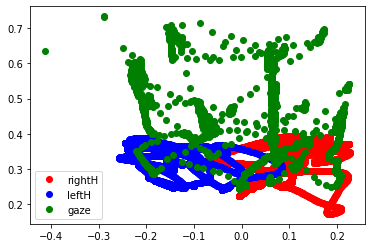

In [10]:
fig = plt.figure()

plt.plot(rightX,rightY,'ro', label='rightH')
plt.plot(leftX,leftY,'bo', label='leftH')
plt.plot(gazeX,gazeY,'go', label='gaze')

plt.legend()
plt.show()
#plt.savefig('all_position.svg')

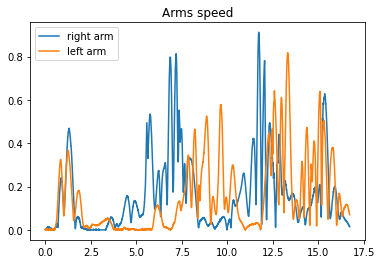

In [15]:
plt.plot(time, rightSpeed, label='right arm')
plt.plot(time, leftSpeed, label='left arm')
plt.title('Arms speed')
plt.legend()
#plt.savefig('arms_speed.svg')

## Events

In [16]:
# Relevant columns: 
# Event name
# Event time (s)

# 101 rows register an event
print("Number of rows registering an event: ",len(dataframe[dataframe['Event name'].notna()]))
print("Total rows (dataframe length): ", len(dataframe))


Number of rows registering an event:  101
Total rows (dataframe length):  3347


(array([3., 0., 0., ..., 0., 0., 0.]),
 array([0.00000000e+00, 4.99999989e-03, 9.99999978e-03, ...,
        1.67199993e+01, 1.67250004e+01, 1.67299995e+01]),
 [<matplotlib.patches.Polygon at 0x7f811285ce20>])

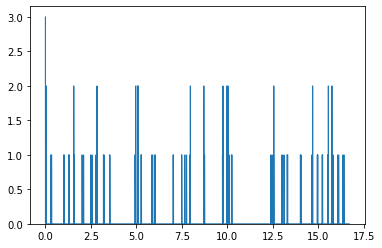

In [17]:
res_events = dataframe[dataframe['Event name'].notna()]
event_times = res_events['Event time (s)']
plt.hist(event_times, dataframe['Frame time (s)'], histtype='step')#, title='Events distribution')

## Trials identification and separation

CSV files typically contain several Trials, the first goal here is to automatically read the CSVs of an experience and extract the trials dataframes separately.

In [18]:
# practice example is from ball_on_bar exercise
practice_ball = "../files/utf8/Ball_on_Bar_-_[Child_-_practice_2_(30s_per_level)]_-_RIGHT_-_11_57.csv"
practice_object = "../files/utf8/Object_Hit_-_[Child_-_practice]_-_RIGHT_-_12_02.csv"
practice_reach = "../files/utf8/Visually_Guided_Reaching_-_[Child_v2_-_practice]_-_LEFT_-_11_49.csv"
practice_reach2 = "../files/utf8/Visually_Guided_Reaching_-_[Child_v2_-_practice]_-_RIGHT_-_11_47.csv"

ball = "../files/utf8/Ball_on_Bar_-_Child_-_RIGHT_-_11_59.csv"
object_hit = "../files/utf8/Object_Hit_-_Child_-_RIGHT_-_12_02.csv"

circuit = "../files/utf8/Circuit_Exo_-_[b_Circuit1_(youngerchildren)]_-_RIGHT_-_12_09.csv"
circuit2 = "../files/utf8/Circuit_Exo_-_[c_Circuit1_rotated_(youngerchildren)]_-_RIGHT_-_12_11.csv"
circuit3 = "../files/utf8/Circuit_Exo_-_[Circuit2exo_ExTrialLisaD(youngerchildren)]_-_RIGHT_-_12_05.csv"

reaching = "../files/utf8/Visually_Guided_Reaching_-_Child_v2_(4_target)_-_LEFT_-_11_50.csv"


#object:     390       -3
#ball :      360       -6
#circuit :   328       -
#reaching:   336       -3



Line space problem, when reading the CSV with the pd.read_csv method, the header size difference between the file types has to be taken into account.  
examples: (requires to change 'skiprows' individually with the values cited above)

In [19]:
#FILEPATH = practice_object
#FILEPATH = practice_ball
#FILEPATH = object_hit
FILEPATH = circuit2
# The first rows don't include tracking data -> skiprows
results = pd.read_csv(FILEPATH,encoding= 'unicode_escape', sep=',',skiprows = 328, parse_dates=[0,1,2])
# Sorted by Frame number
results.head()

,Trial #,TP Row,Block Row,Sample duration (s),Sample count,Event name,Event time (s),Video frame sent,Video frame ACKed,Frame #,...,Left: Shoulder angle,Left: Elbow angle,Left: Shoulder velocity,Left: Elbow velocity,Left: Shoulder acceleration,Left: Elbow acceleration,Left: Cmd shoulder torque,Left: Cmd elbow torque,Video frame interval time,Video frame drop count
0,1,1,1,0.001,62905.0,TASK_BUTTON_15_CLICKED,0.0,NaN,NaN,0,...,0.203705,1.547694,-0.220510,-0.143811,-9.587379e+00,9.587379,0.0,0.0,7.999999,0
1,NaN,NaN,NaN,NaN,NaN,Gaze saccade start,0.0,Video Frame 0,NaN,1,...,0.203484,1.547560,-0.220510,-0.134223,-1.776357e-09,9.587379,0.0,0.0,7.999999,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,...,0.203273,1.547406,-0.210922,-0.153398,9.587379e+00,-19.174759,0.0,0.0,7.999999,0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,...,0.203053,1.547272,-0.220510,-0.134223,-9.587379e+00,19.174759,0.0,0.0,7.999999,0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,...,0.202842,1.547138,-0.210922,-0.134223,9.587379e+00,0.000000,0.0,0.0,7.999999,0


Skipping the lines from a given 

### Extract dataframes first version

In [20]:
ENCODE = 'utf_8'
def extract_dataframesv1(file, offset=0):
    # Line detection
    trials = []
    with open(file, encoding=ENCODE) as infile:
        for cnt, line in enumerate(infile):
            if "Trial #" in line:
                #print("Line {}".format(cnt))
                trials.append(cnt)

        #print("Line end :", cnt)
        trials.append(cnt + 17)
        #process = subprocess.Popen(["wc", "-l", EXERCISE])#, "copy.sh"])
    # Dataframes
    dfs = []
    for i, j in enumerate(trials[:-1]):
        dfs.append(pd.read_csv(file,encoding= 'utf8', sep=',', low_memory=False,
                                skiprows = j-offset, nrows=trials[i+1]-trials[i] -17))

    return dfs

In [21]:
EXERCISE = ball
if EXERCISE[14] == 'B':
    dfs = extract_dataframesv1(EXERCISE, offset=6)
elif EXERCISE[14] == 'C':
    dfs = extract_dataframesv1(EXERCISE, offset=0)
elif EXERCISE[14] == 'O' or 'R' :
    dfs = extract_dataframesv1(EXERCISE, offset=3)


In [22]:
dfs[1]

,Trial #,TP Row,Block Row,Sample duration (s),Sample count,Event name,Event time (s),Video frame sent,Video frame ACKed,Frame #,...,Left: Shoulder angle,Left: Elbow angle,Left: Shoulder velocity,Left: Elbow velocity,Left: Shoulder acceleration,Left: Elbow acceleration,Left: Cmd shoulder torque,Left: Cmd elbow torque,Video frame interval time,Video frame drop count
0,2.0,2.0,2.0,0.001,61899.0,NaN,NaN,NaN,NaN,0,...,0.988096,0.970706,0.488956,-1.092961,9.587379e+00,-9.587379e+00,-0.813206,-0.567194,9.000000,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,...,0.988576,0.969623,0.479369,-1.083374,-9.587379e+00,9.587379e+00,-0.805245,-0.561584,9.000000,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,...,0.989046,0.968549,0.469782,-1.073787,-9.587379e+00,9.587379e+00,-0.797132,-0.555867,9.000000,0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,...,0.989525,0.967476,0.479369,-1.073787,9.587379e+00,0.000000e+00,-0.789157,-0.550249,9.000000,0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Video Frame 0,NaN,4,...,0.989995,0.966421,0.469782,-1.054612,-9.587379e+00,1.917476e+01,-0.781282,-0.544700,9.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61894,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61894,...,0.676622,1.356090,0.680704,-0.546481,0.000000e+00,8.881784e-10,-0.383442,-0.191434,8.998871,0
61895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61895,...,0.677302,1.355544,0.680704,-0.546481,-8.881784e-10,8.881784e-10,-0.384322,-0.192020,8.998871,0
61896,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Video Frame 7423,61896,...,0.677983,1.354988,0.680704,-0.556068,8.881784e-10,-9.587379e+00,-0.385205,-0.192608,8.998871,0
61897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61897,...,0.678664,1.354441,0.680704,-0.546481,0.000000e+00,9.587379e+00,-0.385968,-0.193111,8.998871,0


In [23]:
trial1 = Trial(dfs[0], name='trial1', filter=None)

#trial1.kinematics
#dfs[0]['Right: Hand position Y']

In [24]:
evt_list = list(dfs[0][dfs[0]['Event name'].notna()]['Event name'])
from collections import Counter
print(dict(Counter(evt_list)))

{'Gaze saccade start': 72, 'Gaze saccade end': 72, 'Gaze fixation start': 15, 'Gaze fixation end': 15, 'CENTRAL_TARGET_ON': 1, 'CENTRAL_TARGET_REACHED': 1, 'SECOND_TARGET_ON': 8, 'SECOND_TARGET_REACHED': 9, 'SECOND_TARGET_HELD': 8, 'THIRD_TARGET_ON': 8, 'THIRD_TARGET_REACHED': 9, 'THIRD_TARGET_HELD': 8, 'FOURTH_TARGET_ON': 8, 'FOURTH_TARGET_REACHED': 8, 'FOURTH_TARGET_HELD': 7, 'FIRST_TARGET_ON': 7, 'FIRST_TARGET_REACHED': 8, 'FIRST_TARGET_HELD': 7, 'Gaze blink start': 2, 'Gaze blink end': 2, 'FIRST_TARGET_EXITED': 1, 'THIRD_TARGET_EXITED': 1, 'SECOND_TARGET_EXITED': 1, 'FOURTH_TARGET_EXITED': 1}


The following code lists each saccade start, with its Frame time(s) and Frame #.  

In [25]:
df_event = dfs[0][dfs[0]['Event name'].notna()]
[tuple(x) for x in df_event.loc[df_event['Event name'] == 'Gaze saccade start'][['Frame #','Event time (s)']].values][:5]

[(256.0, 0.256000012),
 (655.0, 0.654999971),
 (1460.0, 1.46000004),
 (1632.0, 1.63199997),
 (1897.0, 1.89699996)]